# Repetition Code Calculations

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import ticker as tick
import numpy as np
import pandas as pd
import statsmodels.stats.proportion as smp
import math
from scipy.stats import binom
from sklearn.linear_model import LinearRegression

from itertools import count as itercnt


import sys
import pickle
np.set_printoptions(threshold=sys.maxsize)

import mpmath

import glob
import json

from mpmath import *

mpmath.prec = 100
mpmath.mp.dps = 100

def binom_cdf(k,n,p):
    x2 = (1-mpmath.mpf(p))
    a = n - k
    b = k + 1
    v = x2**a * mpmath.hyp2f1(a, 1-b, a+1, x2, maxprec = 1000000) / a
    v /= mpmath.beta(a,b)
    return v

CW = 5
CH = 4

In [2]:
def get_rep_code_probs(d_x, d_z, p):
    rep_len = 1
    short_est = np.polyval(np.flip(get_short_estimating_polynomial(d_x, d_z)), p) * d_z * 5
    long_est = np.polyval(np.flip(get_long_estimating_polynomial(d_x, d_z)), p) * d_z * 5
    if  short_est < 0.45 and short_est > long_est:
        #print("here" + str(1) + " "+ str(short_est)+ " " +  str(long_est))
        for m in range(3, 100002, 2):
            new_short_est = 1-binom_cdf((m-1)/2,m, short_est)
            #print("here" + str(m) + " "+ str(float(new_short_est))+ " " +  str(long_est * m))
            if new_short_est < (long_est * m): 
                short_est = float(new_short_est)
                long_est *= m
                rep_len = m
                break
            if m == 100001:
                short_est = float(new_short_est)
                long_est *= m
                rep_len = m
                #print("here")
    return short_est, long_est, rep_len
def get_cnot_probs(short_est, long_est, rep_len):
    short_est *= 2 * rep_len + 1
    long_est *= 2 * rep_len + 1
    return short_est, long_est
def get_patch_q_count(d_x, d_z):
    return (2 * (d_x+2) - 1) * (2 * (d_z+2) - 1)

In [3]:
def get_short_poly(fx_coefs, d_x, d_z):
    return np.eye(1,int((d_x+1)/2)+1,int((d_x+1)/2)).flatten()* np.polyval(np.array(fx_coefs),d_z)

def get_long_poly_o(alpha, beta, d_x, d_z):
    return np.eye(1,int((d_z+1)/2) + 2,int((d_z+1)/2)).flatten()* beta**((d_z+1)/2) *((d_x*2-1) / (d_z*2-1))*d_z* alpha

def get_long_poly(alpha, beta, d_x, d_z):
    return np.eye(1,int((d_z+1)/2) + 2,int((d_z+1)/2)).flatten()* beta**((d_z+1)/2) *((d_x*2-1) / (d_z*2-1))* alpha


def get_short_estimating_polynomial(d_x, dz):
    if d_x == 3:
        return get_short_poly([5.0E2,-7.5E2,2.5E2], 3, dz)
    elif d_x == 5:
        return get_short_poly([26399,-57295,18522], 5, dz)
    elif d_x == 7:
        return get_short_poly([2.87E6, -1.55E7, 2.75E7], 7, dz)
    else:
        return []

def get_long_estimating_polynomial(d_x, dz):
    if d_x == 3:
        return  get_long_poly(0.09, 95, 3, dz)
    elif d_x == 5:
        return  get_long_poly(0.06, 115, 5, dz)
    elif d_x == 7:
        return  get_long_poly(0.03, 125, 7, dz)
    else:
        return []

def get_estimates_short_o(samp_range, d_x, dz):
    estimate_points = np.geomspace(samp_range[0], samp_range[1], 100)
    estimating_polynomials = [get_short_estimating_polynomial(d_x, i) for i in range(dz[0], dz[1]+1, 2)]
    estimates = [np.array([np.polyval(np.flip(ep), i) for i in estimate_points]) for ep in estimating_polynomials]
    return [estimate_points, estimates]

def get_estimates_short(samp_range, d_x, dz):
    estimate_points = np.geomspace(samp_range[0], samp_range[1], 100)
    estimating_polynomials = [get_short_estimating_polynomial(d_x, i) for i in range(dz[0], dz[1]+1, 2)]
    estimates = [np.array([(1 - binom_cdf(0,d_z, min(2/d_z* np.polyval(np.flip(ep), i),1)))/2 for i in estimate_points]) for ep, d_z in zip(estimating_polynomials, range(dz[0], dz[1]+1, 2))]
    return [estimate_points, estimates]

def get_estimates_long_o(samp_range, d_x, dz):
    estimate_points = np.geomspace(samp_range[0], samp_range[1], 100)
    estimating_polynomials = [get_long_estimating_polynomial(d_x, i) for i in range(dz[0], dz[1]+1, 2)]
    estimates = [[np.polyval(np.flip(ep), i) for i in estimate_points] for ep in estimating_polynomials]
    return [estimate_points, estimates]

def get_estimates_long(samp_range, d_x, dz):
    estimate_points = np.geomspace(samp_range[0], samp_range[1], 100)
    estimating_polynomials = [get_long_estimating_polynomial(d_x, i) for i in range(dz[0], dz[1]+1, 2)]
    estimates = [[(1 - binom_cdf(0,d_z, min(2* np.polyval(np.flip(ep), i),1)))/2 for i in estimate_points] for ep, d_z in zip(estimating_polynomials, range(dz[0], dz[1]+1, 2))]
    return [estimate_points, estimates]

In [4]:
p = 1.0E-4
target = 1E-6
d_x = 3
dz_range = range(3, 35, 2)

print("p = " + str(p))
for d_z in dz_range:
    short_est = np.polyval(np.flip(get_short_estimating_polynomial(d_x, d_z)), p) * d_z * 5
    long_est = np.polyval(np.flip(get_long_estimating_polynomial(d_x, d_z)), p) * d_z * 5
    rep_len = 1
    print(str(d_x) + "x"+str(d_z) + " p_x: " + str(short_est) + " p_z: " + str(long_est) )
    short_est, long_est, rep_len = get_rep_code_probs(d_x, d_z, p)
#     print(str(d_x) + "x"+str(d_z) + " p_x: " + str(short_est) + " p_z: " + str(long_est) )
    if rep_len != 1:
        print(" d_r:" +str(rep_len) + " p_x: " + str(short_est) + " p_z: " + str(long_est) )
        short_est, long_est = get_cnot_probs(short_est, long_est, rep_len)
        print(" d_r_cnot:" +str(rep_len) + " p_x: " + str(short_est) + " p_z: " + str(long_est) )
        print(" n_q = " + str(get_patch_q_count(d_x, d_z)  * rep_len ))
        if long_est > target or short_est > target:
            print("  not_possible")
            continue
        

p = 0.0001
3x3 p_x: 0.000375 p_z: 0.0001218375
 d_r:3 p_x: 4.2176953125e-07 p_z: 0.0003655125
 d_r_cnot:3 p_x: 2.95238671875e-06 p_z: 0.0025585875
 n_q = 243
  not_possible
3x5 p_x: 0.0022500000000000003 p_z: 1.07171875e-06
 d_r:5 p_x: 1.1352216239648442e-07 p_z: 5.35859375e-06
 d_r_cnot:5 p_x: 1.2487437863613286e-06 p_z: 5.894453125e-05
 n_q = 585
  not_possible
3x7 p_x: 0.006825 p_z: 9.868056490384617e-09
 d_r:9 p_x: 1.8238027162904783e-09 p_z: 8.881250841346155e-08
 d_r_cnot:9 p_x: 3.465225160951909e-08 p_z: 1.6874376598557695e-06
 n_q = 1377
  not_possible
3x9 p_x: 0.015300000000000003 p_z: 9.217096461397064e-11
 d_r:13 p_x: 3.1063907049072957e-10 p_z: 1.1982225399816184e-09
 d_r_cnot:13 p_x: 8.387254903249698e-09 p_z: 3.23520085795037e-08
 n_q = 2457
3x11 p_x: 0.028875000000000005 p_z: 8.663582996651788e-13
 d_r:21 p_x: 3.138831693234673e-12 p_z: 1.8193524292968754e-11
 d_r_cnot:21 p_x: 1.3496976280909095e-10 p_z: 7.823215445976565e-10
 n_q = 4725
3x13 p_x: 0.04875 p_z: 8.17054636

In [7]:
def plot_estimates(W, H, filename, probs, dz_s):
    fig, ((ax1)) = plt.subplots(1, 1)
    plt.rc('text', usetex=True)
    ax1.set_xscale("log", nonpositive='clip')
    ax1.set_yscale("log", nonpositive='clip')
    ax1.set_xlabel("Physical Error Rate")
    ax1.set_ylabel("Logical Error Rate")
    for i in range(len(probs)):
        d = i *2 +dz_s
        s = probs[i]
        x = np.array(s[1])
        y = np.array(s[0])
        ax1.plot(x, y, label=f'$d_Z={d}$')
    ax1.grid(True, which="both", ls="-")
    ax1.legend()
    fig = plt.gcf()
    fig.set_size_inches(W, H)
    fig.tight_layout()
    fig.savefig(filename)
def plot_estimate_val(d_x, d_z, p):
    p_x, p_z, m = get_rep_code_probs(d_x, d_z, p)
#     p_x, p_z = get_cnot_probs(p_x, p_z, m)
    if p_x < p_z:
        return p_z
    elif p_x < 2E-16:
        return math.inf
    else:
        return 1.0
def plot_estimate_val_m(d_x, d_z, p):
    p_x, p_z, m = get_rep_code_probs(d_x, d_z, p)
#     p_x, p_z = get_cnot_probs(p_x, p_z, m)
    if p_x < p_z or p_x < 2E-15:
        return m * get_patch_q_count(d_x, d_z)
    else:
        return math.inf

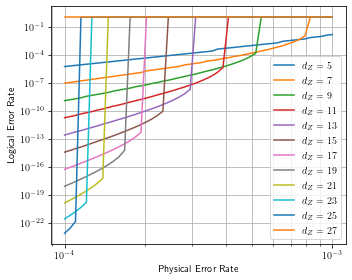

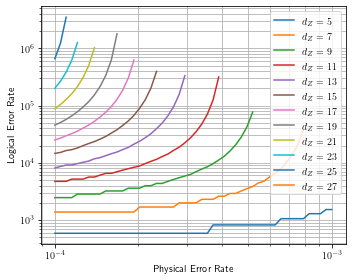

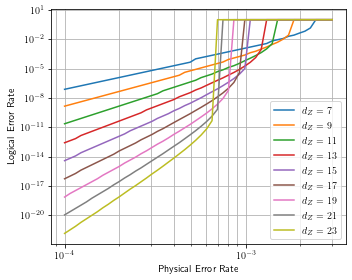

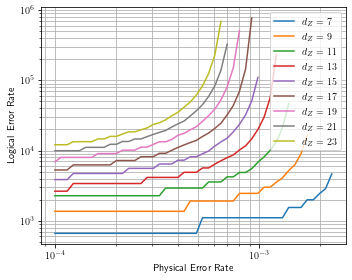

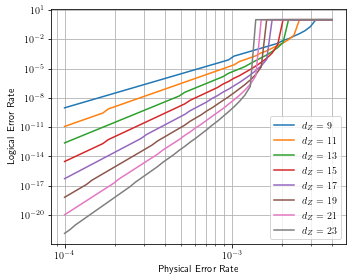

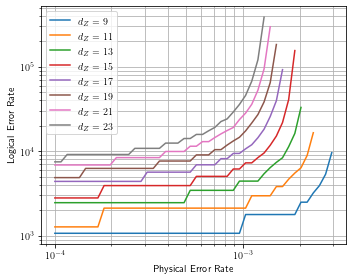

In [8]:
d_x = 3
p_vals = np.geomspace(1E-3, 1E-4, 50)
d_z_range = range(d_x+2,28,2)

estimates = [[[plot_estimate_val(d_x, d_z, p) for p in p_vals],p_vals] for d_z in d_z_range]
plot_estimates(CW, CH, 'paper_images/dx=3_estimate_err.pdf', estimates, d_x+2)

estimates = [[[plot_estimate_val_m(d_x, d_z, p) for p in p_vals],p_vals] for d_z in d_z_range]
plot_estimates(CW, CH, 'paper_images/dx=3_estimate_q_n.pdf', estimates, d_x+2)

d_x = 5
p_vals = np.geomspace(3E-3, 1E-4, 50)
d_z_range = range(d_x + 2,24,2)

estimates = [[[plot_estimate_val(d_x, d_z, p) for p in p_vals],p_vals] for d_z in d_z_range]
plot_estimates(CW, CH, 'paper_images/dx=5_estimate_err.pdf', estimates, d_x + 2)

estimates = [[[plot_estimate_val_m(d_x, d_z, p) for p in p_vals],p_vals] for d_z in d_z_range]
plot_estimates(CW, CH, 'paper_images/dx=5_estimate_q_n.pdf', estimates, d_x+2)

d_x = 7
p_vals = np.geomspace(4E-3, 1E-4, 50)
d_z_range = range(9,24,2)

estimates = [[[plot_estimate_val(d_x, d_z, p) for p in p_vals],p_vals] for d_z in d_z_range]
plot_estimates(CW, CH, 'paper_images/dx=7_estimate_err.pdf', estimates, d_x + 2)
estimates = [[[plot_estimate_val_m(d_x, d_z, p) for p in p_vals],p_vals] for d_z in d_z_range]
plot_estimates(CW, CH, 'paper_images/dx=7_estimate_q_n.pdf', estimates, d_x+2)